In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from Learners import *
from econml.grf import RegressionForest
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### Data

In [2]:
import pandas as pd
df=pd.read_csv('data.csv',index_col=False)
df.head()

,sex,yob,g2000,g2002,g2004,p2000,p2002,p2004,treatment,cluster,voted,hh_id,hh_size,numberofnames,p2004_mean,g2004_mean
0,male,1941,yes,yes,yes,no,yes,No,Civic Duty,1,No,1.0,2,21,0.095238,0.857143
1,female,1947,yes,yes,yes,no,yes,No,Civic Duty,1,No,1.0,2,21,0.095238,0.857143
2,male,1951,yes,yes,yes,no,yes,No,Hawthorne,1,Yes,2.0,3,21,0.047619,0.857143
3,female,1950,yes,yes,yes,no,yes,No,Hawthorne,1,Yes,2.0,3,21,0.047619,0.857143
4,female,1982,yes,yes,yes,no,yes,No,Hawthorne,1,Yes,2.0,3,21,0.047619,0.857143


In [3]:
df.loc[df['sex']=='male', 'sex']=0
df.loc[df['sex']=='female', 'sex']=1
df['age']=2019-df['yob']
for item in ['g2000','g2002','p2000','p2002','p2004','voted']:
    df.loc[df[item]=='yes', item]=1
    df.loc[df[item]=='Yes', item]=1
    df.loc[df[item]=='no', item]=0
    df.loc[df[item]=='No', item]=0

In [4]:
df = df[(df['treatment']==' Control') | (df['treatment']==' Neighbors')]
df.loc[df['treatment']==' Control', 'treatment']=0
df.loc[df['treatment']==' Neighbors', 'treatment']=1

In [5]:
df.head()

,sex,yob,g2000,g2002,g2004,p2000,p2002,p2004,treatment,cluster,voted,hh_id,hh_size,numberofnames,p2004_mean,g2004_mean,age
5,0,1981,0,0,yes,0,0,0,0,1,0,3.0,3,21,0.047619,0.904762,38
6,1,1959,1,1,yes,0,1,0,0,1,1,3.0,3,21,0.047619,0.904762,60
7,0,1956,1,1,yes,0,1,0,0,1,1,3.0,3,21,0.047619,0.904762,63
8,1,1968,0,0,yes,0,1,0,0,1,0,4.0,2,21,0.047619,0.904762,51
9,0,1967,1,1,yes,0,1,0,0,1,0,4.0,2,21,0.047619,0.904762,52


In [6]:
X=np.array(df[['sex','age','g2000','g2002','p2000','p2002','p2004']], dtype=np.int)
y=np.array(df['voted'],dtype=np.int)
treatment=np.array(df['treatment'],dtype=np.int)

In [7]:
print(X[treatment==1].shape,X[treatment==0].shape)

(38201, 7) (191243, 7)


In [8]:
38201/(191243+38201)

0.16649378497585468

### Honest RF

In [ ]:
# T
learner_t = BaseTClassifier(learner0=RegressionForest(), learner1=RegressionForest(), type_=1)
cate_t_honest = learner_t.get_cate(X, y, treatment).reshape(-1)
# S
learner_s = BaseSClassifier(learner=RegressionForest(), type_=1)
cate_s_honest = learner_s.get_cate(X, y, treatment).reshape(-1)
# X

In [ ]:
learner_x = BaseXClassifier(learner=RegressionForest(), cate_learner=RegressionForest(),type_=1)
cate_x_honest = learner_x.get_cate(X[:1000],y[:1000],treatment[:1000],p=0.5).reshape(-1)

In [ ]:
from econml.metalearners import XLearner
est = XLearner(models=RegressionForest(),
              propensity_model=RandomForestClassifier(),
              cate_models=RandomForestRegressor())

In [ ]:
est.fit(y[:1000],treatment[:1000], X=X[:1000])

In [ ]:
cate_x_honest = est.const_marginal_effect(X)

In [ ]:
cate_t_honest

In [ ]:
cate_s_honest

In [ ]:
cate_x_honest

In [ ]:
np.corrcoef(cate_t_honest, cate_s_honest)

In [ ]:
np.corrcoef(cate_t_honest, cate_z_honest)

### RF

In [ ]:
# T
learner_t = BaseTClassifier(learner0=RandomForestClassifier(max_leaf_nodes=3000), learner1=RandomForestClassifier(max_leaf_nodes=3000))
cate_t_gt = learner_t.get_cate(X, y, treatment)
# S
learner_s = BaseSClassifier(learner=RandomForestClassifier())
cate_s_gt = learner_s.get_cate(X, y, treatment)
# X
learner_x = BaseXClassifier(learner=RandomForestClassifier(), cate_learner=RandomForestRegressor(), prospensity_learner=RandomForestClassifier())
cate_x_gt = learner_x.get_cate(X, y, treatment,p=0.5)

In [ ]:
cate_t_gt

In [ ]:
cate_s_gt

In [ ]:
cate_x_gt

In [ ]:
np.corrcoef(cate_t_gt, cate_s_gt)

In [ ]:
np.corrcoef(cate_t_gt, cate_x_gt)

In [ ]:
cate_t_gt.max()

In [107]:
def eval(cate,gt):
    rmse, variance, bias = [],[],[]
    for i in range(len(sample)):
        variance.append(np.var(cate[i]))
        rmse.append(mean_squared_error(gt[i], cate[i], squared=False))
        bias.append(np.sum((cate[i] - ytest)**2) / len(ytest))
    return rmse, variance, bias

In [105]:
def visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3):
    x = 1/1000*len(X)*np.array(sample)
    fig, ax = plt.subplots(3, 1, figsize=(12, 8),sharex=True,subplot_kw=dict(frameon=False))
    ax[0].plot(x, v2, color="green", marker=".", label="S-Learner")
    ax[1].plot(x, b2, color="green",marker=".",label="S-Learner")
    ax[2].plot(x, r2, color="green", marker=".", label="S-Learner")
    ax[0].plot(x, v1, color="grey", marker="^", label="T-Learner")
    ax[1].plot(x, b1, color="grey",marker="^",label="T-Learner")
    ax[2].plot(x, r1, color="grey", marker="^", label="T-Learner")
    ax[0].plot(x, v3, color="blue", marker="|", label="X-Learner")
    ax[1].plot(x, b3, color="blue",marker="|",label="X-Learner")
    ax[2].plot(x, r3, color="blue", marker="|", label="X-Learner")
    ax[0].legend(bbox_to_anchor=(1.05, 0), loc='upper left', ncol=1)
    ax[0].set_ylabel('Average Variance')
    ax[1].set_ylabel('Average Bias')
    ax[2].set_ylabel('RMSE')
    ax[2].set_xlabel('Training Size (in 1000)')
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    fig.show()

In [100]:
ratio = len(X[treatment==1])/(len(X[treatment==0])+len(X[treatment==1]))
b,a = int(ratio*100000), int((1-ratio)*100000)
Xtest = np.concatenate((X[treatment==0][:a],X[treatment==1][:b]),axis=0)
ytest = np.concatenate((y[treatment==0][:a],y[treatment==1][:b]),axis=0)
X_0, X_1, y_0,y_1 = X[treatment==0][a:], X[treatment==1][b:], y[treatment==0][a:],y[treatment==1][b:]
#X_0, X_1, y_0,y_1 = X[treatment==0], X[treatment==1], y[treatment==0],y[treatment==1]
learner_t_gt = BaseTClassifier(learner0=RegressionForest(), learner1=RegressionForest(), type_=1)
learner_t_gt.fit(X,y,treatment)
sample = [0.001,0.002,0.005,0.008,0.01,0.02,0.05,0.1,0.2,0.3]

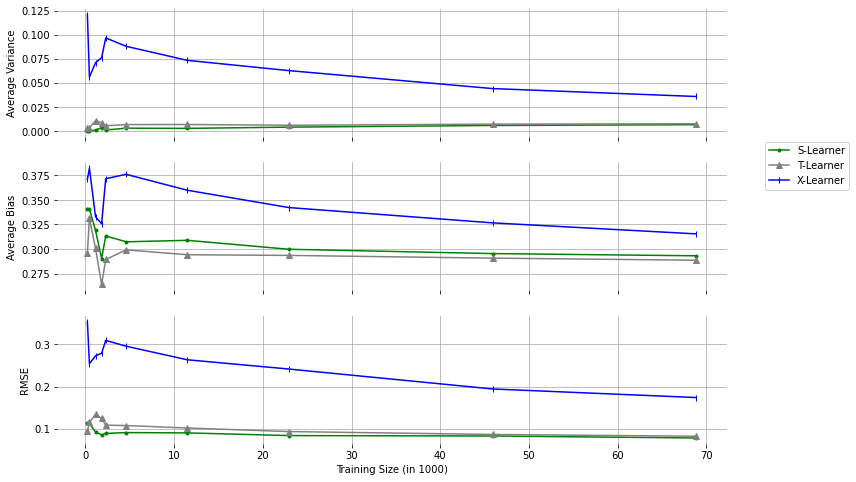

In [110]:
cate_t,cate_s,cate_x, gt = [],[],[],[]
for i in sample:
    len0, len1 = int(i*len(X[treatment==0])), int(i*len(X[treatment==1]))
    ind0 = np.random.choice(len(X_0),len0,replace=False)
    ind1 = np.random.choice(len(X_1),len1,replace=False)
    Xtrain = np.concatenate((X_0[ind0],X_1[ind1]),axis=0)
    ytrain = np.concatenate((y_0[ind0],y_1[ind1]),axis=0)
    #Xtest = np.concatenate((X_0[np.delete(np.arange(len(X_0)),ind0)],X_1[np.delete(np.arange(len(X_1)),ind1)]),axis=0)
    gt.append(learner_t_gt.get_cate2(Xtrain,ytrain,Xtest,len0, len1,0).reshape(-1))
    learner_t = BaseTClassifier(learner0=RegressionForest(), learner1=RegressionForest(), type_=1)
    cate_t.append(learner_t.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1))
    learner_s = BaseSClassifier(learner=RegressionForest(), type_=1)
    cate_s.append(learner_s.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1))
    learner_x = BaseXClassifier(learner=RandomForestClassifier(), cate_learner=RandomForestRegressor(), prospensity_learner=RandomForestClassifier())
    cate_x.append(learner_x.get_cate2(Xtrain,ytrain,Xtest,len0, len1,p=0.5))
r1,v1,b1 = eval(cate_t,gt)
r2,v2,b2 = eval(cate_s,gt)
r3,v3,b3 = eval(cate_x,gt)
visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3)

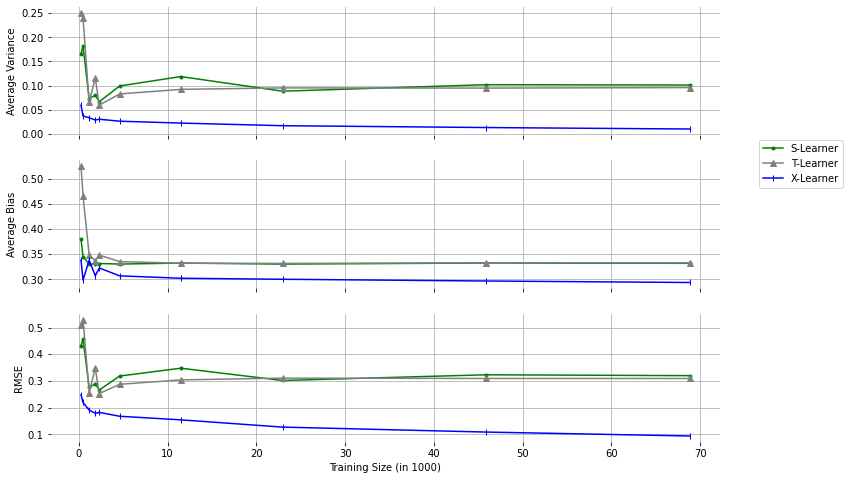

In [111]:
cate_t,cate_s,cate_x, gt = [],[],[],[]
for i in sample:
    len0, len1 = int(i*len(X[treatment==0])), int(i*len(X[treatment==1]))
    ind0 = np.random.choice(len(X_0),len0,replace=False)
    ind1 = np.random.choice(len(X_1),len1,replace=False)
    Xtrain = np.concatenate((X_0[ind0],X_1[ind1]),axis=0)
    ytrain = np.concatenate((y_0[ind0],y_1[ind1]),axis=0)
    #Xtest = np.concatenate((X_0[np.delete(np.arange(len(X_0)),ind0)],X_1[np.delete(np.arange(len(X_1)),ind1)]),axis=0)
    gt.append(learner_t_gt.get_cate2(Xtrain,ytrain,Xtest,len0, len1,0).reshape(-1))
    learner_t = BaseTClassifier(learner0=LogisticRegression(), learner1=LogisticRegression(), type_=1)
    cate_t.append(learner_t.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1))
    learner_s = BaseSClassifier(learner=LogisticRegression(), type_=1)
    cate_s.append(learner_s.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1))
    learner_x = BaseXClassifier(learner=LogisticRegression(), cate_learner=RandomForestRegressor(), prospensity_learner=LogisticRegression())
    cate_x.append(learner_x.get_cate2(Xtrain,ytrain,Xtest,len0, len1,p=0.5))
r1,v1,b1 = eval(cate_t,gt)
r2,v2,b2 = eval(cate_s,gt)
r3,v3,b3 = eval(cate_x,gt)
visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


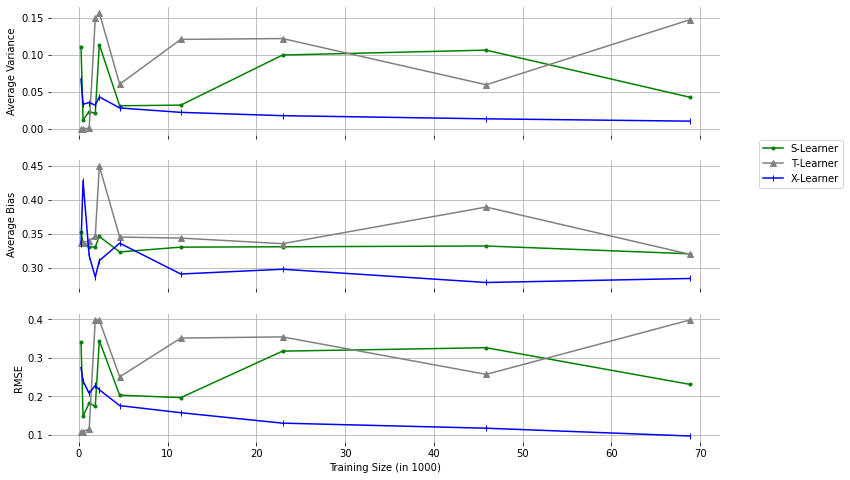

In [112]:
cate_t,cate_s,cate_x, gt = [],[],[],[]
for i in sample:
    len0, len1 = int(i*len(X[treatment==0])), int(i*len(X[treatment==1]))
    ind0 = np.random.choice(len(X_0),len0,replace=False)
    ind1 = np.random.choice(len(X_1),len1,replace=False)
    Xtrain = np.concatenate((X_0[ind0],X_1[ind1]),axis=0)
    ytrain = np.concatenate((y_0[ind0],y_1[ind1]),axis=0)
    #Xtest = np.concatenate((X_0[np.delete(np.arange(len(X_0)),ind0)],X_1[np.delete(np.arange(len(X_1)),ind1)]),axis=0)
    gt.append(learner_t_gt.get_cate2(Xtrain,ytrain,Xtest,len0, len1,0).reshape(-1))
    learner_t = BaseTClassifier(learner0=MLPClassifier(), learner1=MLPClassifier(), type_=1)
    cate_t.append(learner_t.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1))
    learner_s = BaseSClassifier(learner=MLPClassifier(), type_=1)
    cate_s.append(learner_s.get_cate2(Xtrain,ytrain,Xtest,len0, len1).reshape(-1))
    learner_x = BaseXClassifier(learner=MLPClassifier(), cate_learner=RandomForestRegressor(), prospensity_learner=MLPClassifier())
    cate_x.append(learner_x.get_cate2(Xtrain,ytrain,Xtest,len0, len1,p=0.5))
r1,v1,b1 = eval(cate_t,gt)
r2,v2,b2 = eval(cate_s,gt)
r3,v3,b3 = eval(cate_x,gt)
visualize(r1,v1,b1,r2,v2,b2,r3,v3,b3)